In [21]:
import json
import os
import boto3

import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd
import numpy as np

from time import ctime

from boto3 import session
from botocore.exceptions import ClientError

In [22]:
# Set environment variables
client = boto3.client(
    "s3",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
)

### For reference:
- Code from Pat: https://gist.github.com/pjsier/3a813244545163e3cdf276328e539186
- AWS S3 documentation: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html#S3.Client.list_objects_v2

In [23]:
# Prefix can also be created with datetime.strftime
snapshots = {}
providers = ['lime','bird']

for org in providers:
    i = 0
    if org not in snapshots:
        snapshots[org] = []
        
    for snapshot in client.list_objects_v2(
    Bucket=os.getenv("S3_BUCKET"), Prefix=org+"/2020/08/29", MaxKeys=1000)["Contents"]:
    # Ignore irrelevant keys
        if "samplestring" not in snapshot["Key"]:
            #print("Valid key", i)
            snapshot_obj = client.get_object(Bucket=os.getenv("S3_BUCKET"), Key=snapshot["Key"])
            snapshot_data = json.load(snapshot_obj["Body"])
            snapshots[org].append(snapshot_data)
            i+=1
    
    print(f"Loaded {len(snapshots[org])} for {org}")

Loaded 558 for lime
Loaded 837 for bird


In [24]:
def extract_time(json_obj):
    '''
    Check if a JSON object has time
    '''
    try:
        return int(json_obj['last_updated'])
    
    except KeyError:
        return 0

    
def sort_by_time(list_json):
    '''
    Sort a list of JSON objects by a certain key
    
    Inputs:
    - list_json (list): a list of JSON objects

    Returns: a sorted list
    '''
    return list_json.sort(key=extract_time, reverse=True)

In [25]:
for provider, data in snapshots.items():
    print("Sorting", provider, "now...")
    sort_by_time(data)

Sorting lime now...
Sorting bird now...


In [26]:
# Look at the Lime data
snapshots['lime'][0]

{'last_updated': 1598742832,
 'ttl': 0,
 'version': '1.0',
 'data': {'stations': [{'station_id': 'chicago',
    'num_bikes_available': 1427,
    'num_docks_available': 999999,
    'is_installed': 1,
    'is_renting': 1,
    'is_returning': 1,
    'last_reported': 1598742832}]}}

In [27]:
snapshots['lime'][1]

{'last_updated': 1598742666,
 'ttl': 0,
 'version': '1.0',
 'data': {'bikes': [{'bike_id': '',
    'lat': '41.7495',
    'lon': '-87.5529',
    'is_reserved': 0,
    'is_disabled': 0,
    'vehicle_type': 'scooter'},
   {'bike_id': '',
    'lat': '41.7338',
    'lon': '-87.5533',
    'is_reserved': 0,
    'is_disabled': 0,
    'vehicle_type': 'scooter'},
   {'bike_id': '',
    'lat': '41.7551',
    'lon': '-87.5571',
    'is_reserved': 0,
    'is_disabled': 0,
    'vehicle_type': 'scooter'},
   {'bike_id': '',
    'lat': '41.7551',
    'lon': '-87.5571',
    'is_reserved': 0,
    'is_disabled': 0,
    'vehicle_type': 'scooter'},
   {'bike_id': '',
    'lat': '41.758',
    'lon': '-87.5589',
    'is_reserved': 0,
    'is_disabled': 0,
    'vehicle_type': 'scooter'},
   {'bike_id': '',
    'lat': '41.751',
    'lon': '-87.5589',
    'is_reserved': 0,
    'is_disabled': 0,
    'vehicle_type': 'scooter'},
   {'bike_id': '',
    'lat': '41.7401',
    'lon': '-87.5623',
    'is_reserved': 0,


In [28]:
# Look at the Bird data
snapshots['bird'][0]

{'data': {'bikes': [{'bike_id': 'adbb75c7-c562-4b64-b17b-f8d06ce9d6d9',
    'lat': 41.906451,
    'lon': -87.671395,
    'is_disabled': 0,
    'is_reserved': 0},
   {'bike_id': 'a9950207-74d9-4a92-a7d4-ea5e664ada76',
    'lat': 41.925754,
    'lon': -87.766357,
    'is_disabled': 0,
    'is_reserved': 0},
   {'bike_id': 'dfcfa868-2191-4388-8428-fef913bbb7c2',
    'lat': 41.946696,
    'lon': -87.687974,
    'is_disabled': 0,
    'is_reserved': 0},
   {'bike_id': 'b8d2de7f-bb67-4042-8235-00aee94a4d8a',
    'lat': 41.938756,
    'lon': -87.746907,
    'is_disabled': 0,
    'is_reserved': 1},
   {'bike_id': '01421e62-b9df-4c9d-8556-8f0c9eecfda4',
    'lat': 41.939072,
    'lon': -87.766504,
    'is_disabled': 0,
    'is_reserved': 0},
   {'bike_id': '951c8699-a6f9-4dac-9843-6cc8378cf616',
    'lat': 41.939068,
    'lon': -87.726472,
    'is_disabled': 0,
    'is_reserved': 0},
   {'bike_id': '849d41a7-1d28-4f74-8b8c-676619aefc2a',
    'lat': 41.95335,
    'lon': -87.752008,
    'is_disabl

In [29]:
snapshots['bird'][1]

{'last_updated': 1598742832,
 'data': {'geofencing_zones': [{'geofencing_zone_id': '2e0428c2-82cc-40e4-9ae2-5ecd5d14481c',
    'lat': 41.82907032499653,
    'lon': -87.67723705371576,
    'zone_area': {'type': 'MultiPolygon',
     'coordinates': [[[[-87.664274, 42.021308],
        [-87.664192, 42.02126],
        [-87.664015, 42.02134],
        [-87.663815, 42.020458],
        [-87.663734, 42.020369],
        [-87.663933, 42.020325],
        [-87.663891, 42.020189],
        [-87.664013, 42.020185],
        [-87.66386, 42.019667],
        [-87.663933, 42.019611],
        [-87.663885, 42.019523],
        [-87.663648, 42.019512],
        [-87.663644, 42.019381],
        [-87.663862, 42.019356],
        [-87.663875, 42.019212],
        [-87.663992, 42.019193],
        [-87.663986, 42.019084],
        [-87.663721, 42.018749],
        [-87.663361, 42.018591],
        [-87.663288, 42.018442],
        [-87.663338, 42.018159],
        [-87.663418, 42.018157],
        [-87.663278, 42.017773],
   

In [30]:
zip_boundaries = gpd.read_file("https://data.cityofchicago.org/resource/unjd-c2ca.geojson?$limit=9999999")
ca_boundaries = gpd.read_file("https://data.cityofchicago.org/resource/igwz-8jzy.geojson?$limit=9999999")

In [31]:
#print(ctime(snapshots['lime'][1]['last_updated']))
#print(ctime(snapshots['lime'][-1]['last_updated']))

In [32]:
#print(ctime(snapshots['bird'][1]['last_updated']))
#print(ctime(snapshots['bird'][-1]['last_updated']))

In [33]:
def plot_scooters(df_dict, ax):
    '''
    Converts lat/lon to Point and plots Points on a map
    
    Inputs:
    - df_dict: a dictionary with pandas DataFrames, color of markers, and time
    - ax (axis object): axis to plot on
    
    Outputs: an axis object
    '''
    # Plot base layer of community areas    
    ca_boundaries.plot(facecolor="lightgrey", edgecolor="white", ax=ax)
    
    for provider in df_dict:
        
        print("Currently working with:", provider)
        current = df_dict[provider] # This is a dictionary
        
        # Initialize new keys
        current['geo_df'] = None
        current['str_time'] = None
    
        # Create Point objects
        df = pd.DataFrame(current['df']) # CONVERT TO A DATAFRAME
        
        # Make sure lat/lon are numeric
        long = pd.to_numeric(df.lon)
        lat = pd.to_numeric(df.lat)
        
        print("Converting lat/lon to Point objects...")
        geometry = [Point(xy) for xy in zip(long, lat)]
        df = df.drop(['lon', 'lat'], axis=1)
        
        crs = {'init': 'epsg:4326'}
    
        # Add values to new keys
        current['geo_df'] = GeoDataFrame(df, crs=crs, geometry=geometry)
        current['str_time'] = ctime(current['time'])
        
        # Plot the scooters
        print("Plotting...")
        current['geo_df'].plot(ax=ax, color=current['color'], alpha=0.5, markersize=10)

    # Format map
    ax.axis('off')
    axis_title = 'Lime: ' + df_dict['lime']['str_time'] + '        Bird: ' + df_dict['bird']['str_time']
    fig.suptitle('Location of Lime and Bird scooters', fontname='Lato', fontsize=35)
    ax.set_title(axis_title, fontdict={'fontsize':'14', 'fontweight':'1', 'fontname': 'Lato'})
    
    lime_patch = mpatches.Patch(color='green', label='Lime')
    bird_patch = mpatches.Patch(color='blue', label='Bird')
    plt.legend(handles=[lime_patch, bird_patch], loc='lower left', prop={'family': 'Lato'})
    
    #ax.annotate('Source: TK', 
            #xy=(0.1, .08),
            #xycoords='figure fraction', 
            #horizontalalignment='left', 
            #verticalalignment='top',
            #fontsize=12, color='#555555')
       
    fig.savefig('bird_lime_locations.png')
    
    #return ax

In [34]:
df_dict = {}

for org in providers:
    i = 0
    print("Working with...", org)
    if org not in df_dict.keys():
        df_dict[org] = {'df': None, 'color': None, 'time': None} 

    if 'bikes' not in snapshots[org][i]['data']:
        i += 1
        
    df_dict[org]['df'] = snapshots[org][i]['data']['bikes']
    df_dict[org]['time'] = snapshots[org][i]['last_updated']
    
    if org == 'lime':
        df_dict[org]['color'] = 'green'
    elif org == 'bird':
        df_dict[org]['color'] = 'blue'
        
# df_dict

Working with... lime
Working with... bird


Currently working with: lime
Converting lat/lon to Point objects...
Plotting...
Currently working with: bird
Converting lat/lon to Point objects...


//anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
//anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Plotting...


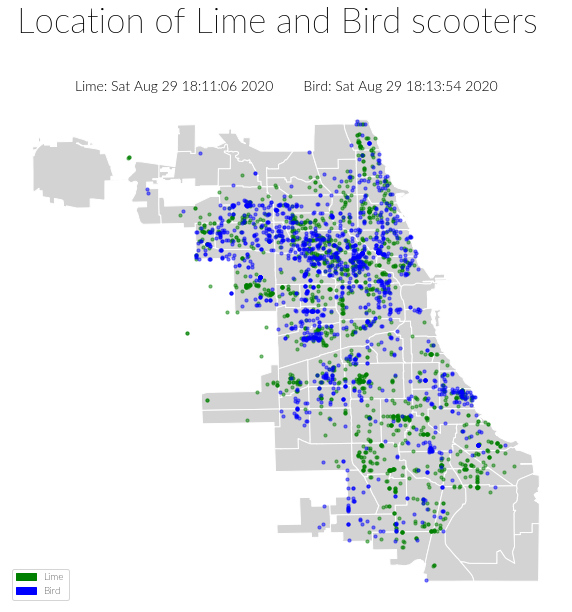

In [35]:
# Test plotting function
fig, test_ax = plt.subplots(1, figsize=(10, 10))
plot_scooters(df_dict, test_ax)

In [36]:
# Make sure that list of JSON objects is sorted by time
# DO NOT RUN YET

'''
sort_by_time(snapshots)

for snapshot in snapshots:
    time = snapshot['last_updated']
    
    # Ignore any snapshots that don't have lat/lon data
    if 'bikes' in snapshot['data'].keys():
        df = pd.DataFrame(snapshot['data']['bikes'])
        plot_scooters(df, 'lon', 'lat', 'lime', time)
        
print("Check folder for images")
'''

'\nsort_by_time(snapshots)\n\nfor snapshot in snapshots:\n    time = snapshot[\'last_updated\']\n    \n    # Ignore any snapshots that don\'t have lat/lon data\n    if \'bikes\' in snapshot[\'data\'].keys():\n        df = pd.DataFrame(snapshot[\'data\'][\'bikes\'])\n        plot_scooters(df, \'lon\', \'lat\', \'lime\', time)\n        \nprint("Check folder for images")\n'